In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
#from pyensembl import EnsemblRelease

In [3]:
if False:    
#     counts_raw = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/counts.tsv', sep='\t', index_col=0)
#     print('Load biomart conversion table')
#     ensembl = EnsemblRelease(77)

#     idx = np.intersect1d(enseml.gene_ids(), counts_raw.index)
#     counts_raw = counts_raw.loc[list(counts_raw.index[:4]) + list(idx)]

#     counts_raw['gene_name'] = ''
#     for fea in counts_raw.index[:4]:
#         counts_raw.loc[fea, 'gene_name'] = fea
#     for eid in idx:
#         counts_raw.loc[eid, 'gene_name'] = ensembl.gene_name_of_gene_id(eid)

#     print('Prepare new counts')
#     counts = counts_raw.set_index('gene_name').T

#     print('Complement feature sheet')
#     var = pd.DataFrame([], index=counts.columns)

#     print('prepare meta sheet')
#     obs = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/read_files.tsv', sep='\t', index_col='Sample').loc[counts.index]
#     obs['R1'] = [i[-1] for i in obs['R1'].str.split('/')]
#     obs['R2'] = [i[-1] for i in obs['R2'].str.split('/')]

#     print('Store to file')
#     fn_counts = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names.tsv'
#     counts.to_csv(fn_counts, sep='\t', index=True)
#     fn_varmeta = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_var.tsv'
#     var.to_csv(fn_varmeta, sep='\t', index=True)
#     obsmeta = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_obs.tsv'
#     obs.to_csv(obsmeta, sep='\t', index=True)

    print('create the dataset')
    fn_counts = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names.tsv'
    counts = pd.read_csv(fn_counts, sep='\t', index_col=0)
    fn_varmeta = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_var.tsv'
    var = pd.read_csv(fn_varmeta, sep='\t', index_col=0)
    obsmeta = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/raw_with_gene_names_obs.tsv'
    obs = pd.read_csv(obsmeta, sep='\t', index_col=0)
    
    
    X = counts.values
    print('Make anndata')
    adata = anndata.AnnData(
        X=X,
        var=var,
        obs=obs,
    )

    print('Write to file')
    fn_counts = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_count.h5ad'
    adata.write(fn_counts)
    
    print('filter and save')
    adata.var_names_make_unique()
    adata = adata[adata.obs_names[:-4], adata.var_names[4:]]
    adata = adata[(adata.obs['#feature'] != 'FALSE')]
    adata.write('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad')

create the dataset


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'batch' as categorical
... storing 'grid' as categorical
... storing 'mask_name' as categorical
... storing '#feature' as categorical
... storing 'doublets' as categorical


Make anndata
Write to file


In [34]:
adata = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad')
adata.var_names_make_unique()

# adata = adata[:, adata.var_names[4:]]

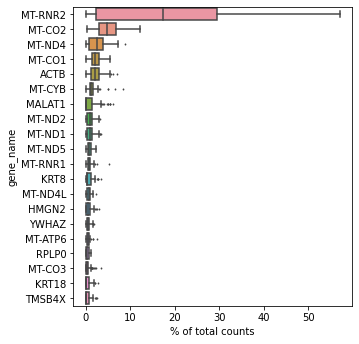

In [35]:
sc.pl.highest_expr_genes(adata, n_top=20)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


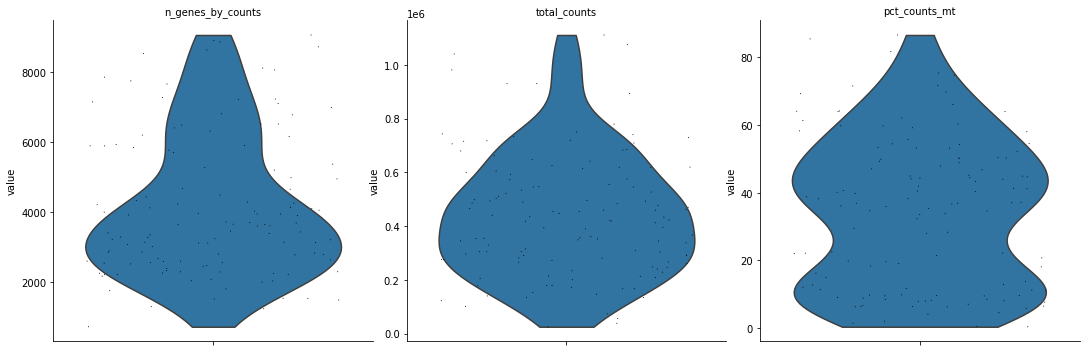

In [36]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

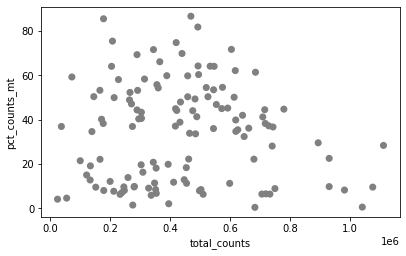

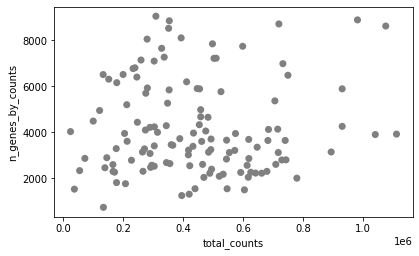

In [37]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', size=200)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', size=200)

In [60]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata, base=2)

In [61]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.5)

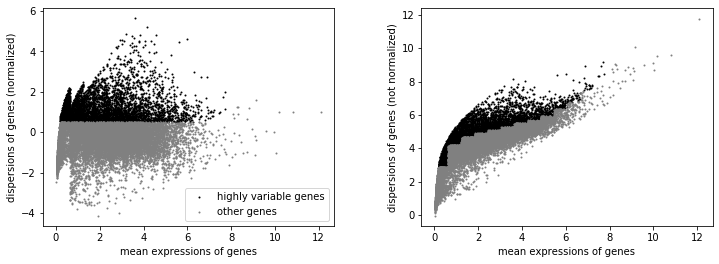

In [62]:
sc.pl.highly_variable_genes(adata)

In [63]:
adata.raw = adata

In [64]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [67]:
sc.tl.pca(adata, svd_solver='arpack')

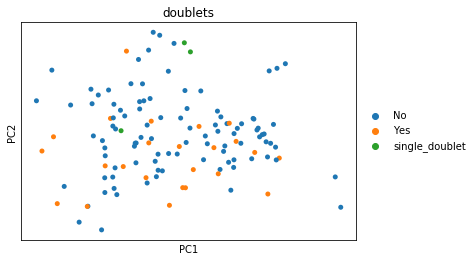

In [71]:
sc.pl.pca(adata, color='doublets', s=100)

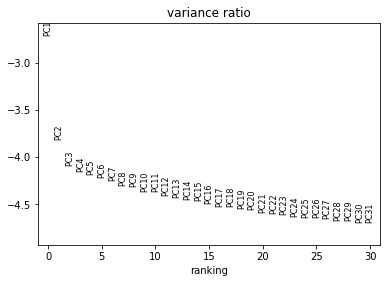

In [72]:
sc.pl.pca_variance_ratio(adata, log=True)